# Ejercicio 3
Este notebook se centra en el estudio de las técnicas de **blind deconvolution**, para ello, primero se presenta un código de ejemplo que aplica un algoritmo particular. Finalmente, se presenta una descripción del problema, un análisis y se obtienen conclusiones.

In [1]:
import matplotlib.pyplot as plt

In [2]:
import scipy.io as sio

In [3]:
import numpy as np

In [4]:
from scipy.signal import convolve

In [5]:
# Read the MATLAB generated file
lenna_mat = sio.loadmat('../resources/lenna.mat')

# Extract the image content
img_original = np.double(lenna_mat['lenna']) / 255

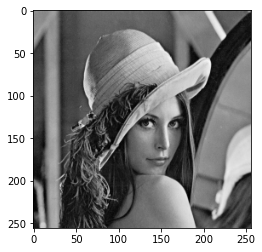

In [6]:
plt.imshow(img_original, cmap='gray')

# Funciones

In [7]:
def get_ideal_lowpass(order, size):
    """ Creates an ideal lowpass 2D filter with the size of the image.
        @param order Order of the kernel or mask
        @param size Size of the image (width, height)
        @return Image sized kernel
    """
    # Extract the width and height from the size parameters
    N, M = size
    
    # Create the kernel
    kernel = np.zeros((N, M))
    n = np.int(order/2)
    m = np.int(M / 2)
    kernel[m-n:m+n+1,m-n:m+n+1] = np.ones((order, order)) / (order**2)
    
    # Return the kernel
    return kernel

In [8]:
def apply_filter(kernel, image):
    """ Apply a 2D filtering to an image in the frequency domain using a kernel.
        with the same size of the image.
        @param kernel Filter kernel or mask
        @param image Image to filter
        @return Resulting image
    """
    image_spectrum = np.fft.fftshift(np.fft.fft2(image))
    kernel_spectrum = np.fft.fftshift(np.fft.fft2(kernel))
    return np.abs(np.fft.fftshift(np.fft.ifft2(image_spectrum * kernel_spectrum)))

In [9]:
def generate_noise(image, snr):
    """ Generates a 2D noise image with a SNR taken relative to the
        provided image.
        @param image Reference image for the power estimation and size settings
        @param snr Signal to Noise Ratio
        @return Noise image
    """
    # Estimate the image standard deviation
    image_std = image.std()
    # Compute the statistical parameters of the noise
    noise_std = np.sqrt(((image_std)**2) * (10**(-snr/10)))
    noise_mean = 0
    # Create the noise image
    return np.random.normal(noise_mean, noise_std, image.shape)

In [10]:
def get_inverse_filter(kernel):
    """ Get the inverse filter of the provided kernel.
        @param kernel Kernel or mask of the image filter
        @return Inverse filter
    """
    return 

In [11]:
def calculate_mse(original, restaured):
    """ Calculates the MSE with the original and the restaured image.
        @param original Original image
        @param restaured Restaured image
        @return Estimation of the MSE
    """
    return (original - restaured).var()

In [12]:
# DISCLAIMER!
# The code presented here is an implementation of the paper that suggests using
# the blind deconvolution richardson-lucy variant. This implementation is currently
# in a pull request to be added to the scikit-image toolbox in the new future.
# Basically, I did not write this code.
#
# https://github.com/scikit-image/scikit-image/pull/4717

def richardson_lucy(image, psf=None, iterations=50, clip=True,
                    return_iterations=False, refine_psf=False,
                    iter_callback=None):
    """Richardson-Lucy deconvolution.
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray, optional
       The point spread function.
    iterations : int, optional
       Number of iterations. This parameter plays the role of
       regularisation.
    clip : boolean, optional
       True by default. If true, pixel value of the result above 1 or
       under -1 are thresholded for skimage pipeline compatibility.
    return_iterations : boolean, optional
        Returns a list of the PSF and the deconvolved image for each iteration.
    refine_psf : boolean, optional
        Refines the passed PSF by means of blind deconvolution.[2]
        If no PSF is passed, this is automatically turned on.
    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
    psf : ndarray
        The last PSF estimate to deconvolve image.
    Examples
    --------
    >>> from skimage import color, data, restoration
    >>> camera = color.rgb2gray(data.camera())
    >>> from scipy.signal import convolve2d
    >>> psf = np.ones((5, 5)) / 25
    >>> camera = convolve2d(camera, psf, 'same')
    >>> camera += 0.1 * camera.std() * np.random.standard_normal(camera.shape)
    >>> deconvolved = restoration.richardson_lucy(camera, psf, 5)
    Notes
    -----
    The Richardson-Lucy algorithm is an iterative algorithm to
    deconvolve an image using a given point spread function (PSF).
    If no PSF is provided, the algorithm performs an "inverse" Richardson
    Lucy algorithm as described in Fish et al., 1995.
    It is an iterative process where the PSF
    and image is deconvolved, respectively.
    It is more noise tolerant than other algorithms,
    such as Ayers-Dainty and the Wiener filter algorithms
    (taken from the paper).
    The algorithm performs well with gaussian PSFs and can recover
    them nicely without any prior knowledge. If one has already an
    educated guess, one should pass the PSF as argument to the function.
    Note, that the PSF should have the same shape as the image,
    and the PSF should be centered.
    Due to its nature, the algorithm may divide by 0.
    The function catches this issue and aborts the iterative process.
    Mostly, the optimal number of iterations is before this error may occur.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    .. [2] Fish, D. A., A. M. Brinicombe, E. R. Pike, and J. G. Walker.
           "Blind deconvolution by means of the Richardson–Lucy algorithm."
           JOSA A 12, no. 1 (1995): 58-65. DOI:`10.1364/JOSAA.12.000058`.
    """

    image = image.astype(np.float)

    # Initialize PSF
    # No PSF was passed, create an ndarray with 0.5 in each cell.
    if psf is None:
        psf = np.full(image.shape, 0.5)
        refine_psf = True  # enable blind deconvolution automatically

    # If PSF was passed and refine_psf option set to true,
    # psf is padded with 0 to allow convolution with image
    # of shape image.shape.
    elif psf is not None and refine_psf:
        psf = _pad_to_shape(image, psf)
        psf = psf.astype(np.float)

    else:
        psf = psf.astype(np.float)

    # Initialize deconvolution image for estimating PSF
    im_deconv = np.full(image.shape, 0.5)
    psf_mirror = psf[::-1, ::-1]

    # Apply algorithm for finite iterations
    for i in range(iterations):
        # Blind deconvolution or refining PSF if an estimate was passed.
        if refine_psf:
            # Deconvolve the PSF
            # Hack: in original publication one would have used `image`,
            #       however, this does not work.
            #       Using `im_deconv` instead recovers PSF.
            relative_blur_psf = im_deconv / convolve(psf, im_deconv, 'same')

            # Check for zeros in PSF, causes the latter code to crash
            if np.count_nonzero(relative_blur_psf == 0):
                break

            else:
                psf *= convolve(relative_blur_psf, im_deconv[::-1, ::-1],
                                'same')

                # Compute inverse again
                psf_mirror = psf[::-1, ::-1]

        # Perform deconvolution
        relative_blur = image / convolve(im_deconv, psf, 'same')
        im_deconv *= convolve(relative_blur, psf_mirror, 'same')
        # Add iteration to list, if desired
        if return_iterations:
            iter_callback(im_deconv, psf, i)

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    if refine_psf:
        return im_deconv, psf
    else:
        return im_deconv

# Generando la versión borrosa con ruido aditivo

In [13]:
# Calculate an ideal low pass filter
kernel = get_ideal_lowpass(7, img_original.shape)

# Apply a blurr effect to the image
img_blurred = apply_filter(kernel, img_original)

In [14]:
# Calculate a noise image with the configured SNR
snr = 30
noise = generate_noise(img_blurred, snr)

# Create the new degraded image
img_blurred_noise = img_blurred + noise

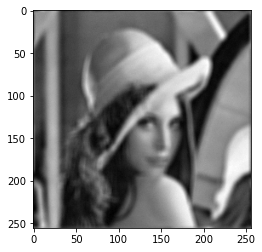

In [15]:
# Plot the iamge
plt.imshow(img_blurred_noise, cmap='gray')

# Restauración

In [16]:
img_blurred_noise_restauration, psf = richardson_lucy(img_blurred_noise, iterations=50)

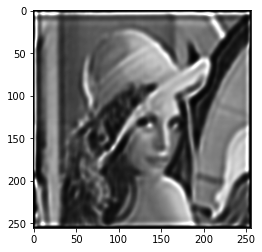

In [17]:
plt.imshow(img_blurred_noise_restauration, cmap='gray')

In [18]:
calculate_mse(img_original, img_blurred_noise_restauration)

0.014678376800622617

# Análisis y conclusiones

Las técnicas de **blind deconvolution** buscan restaurar imágenes que se encuentra degradadas y contaminadas de ruido, sin tener conocimiento a priori (como sí lo hacen otros métodos) del comportamiento del sistema físico que ha degradado a la imagen, ni tampoco la naturaleza del ruido. Para esto, existen dos conjuntos de alternativas. En primer lugar, métodos que buscan **identificar el sistema** para estimar la PSF (Point Spread Function) y con ella recuperar la imagen, y en segundo lugar, métodos que **identifican** y **restauran** en forma simultánea.

Entre los métodos más frecuentes, se encuentran,
* Zero Sheet Separation
* Métodos de estimación parametrizada utilizando procesos ARMA
* Enfoque de la máxima verosimilitud (ML)
* Enfoque de la validación cruzada generalizada (GCV)
* El método IBD
* El método SA
* El algoritmo NAS-RIF

Particularmente, existe un algoritmo muy difundido que se denomina **Richardson-Lucy**. En particular, es un algoritmo iterativo de lenta convergencia, que **no es blind deconvolution** porque requiere conocer cómo es la PSF, no obstante, tiene un mejor comportamiento frente al ruido de la imagen que otros métodos. El concepto esencial del algoritmo consiste en alcanzar el resultado para el cual se maximiza la verosimilitud, y parte de plantear el teorema de Bayes para ello. Existe una variante a este algoritmo, denominada **Blind Richardson-Lucy**, en donde se puede desconocer la PSF, y esta será estimada de forma simultánea con la imagen original, en cada iteración.

Se puede observar que el resultado obtenido es mucho mejor que con el filtro inverso. Más aún, a niveles de SNR donde el filtro inverso no puede trabajar, el resultado de la deconvolución con el algoritmo de Richardson-Lucy es prometedor. Esto se contrasta con las conclusiones obtenidas en [4], según las cuales este algoritmo tiene un mejor comportamiento frente al ruido, con respecto a otros algoritmos.

## Referencias
* [1] Deepa Kundur, Dimitrios Hatzinakos, *Blind Image Deconvolution*, 1996
* [2] Mark R. Banham, Aggelos K. Katsaggelos, *Digital Image Restoration*, 1997
* [3] William Hadley Richardson, *Bayesian-Based Iterative Method of Image Restoration*, 1972
* [4] D. A. Fish, A. M. Brinicombe, E. R. Pike, *Blind deconvolution by means of the Richardson-Lucy algorithm*
* [5] David S. C. Biggs, Mark Andrews, *Acceleration of iterative image restoration algorithms*
* [6] K. T. Lay Aggelos K. Katsaggelos, *Image identification and restoration based on the expectation-maximization algorithm*
* [7] Reginald L. Lagendijk, Jan Biemond, Dick E. Boekee, *Identification and Restoration of Noisy Blurred Images using the Expectation-Maximization Algorithm*